In [31]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt

In [9]:
df = pd.read_csv("data_sources/queries/sample_one_percent.csv")

In [10]:
df["route"] = df['pickup_community_area'].astype(str) + "-" + df['dropoff_community_area'].astype(str)

In [11]:
df["trip_start_timestamp"] = pd.to_datetime(df["trip_start_timestamp"])
df["trip_end_timestamp"] = pd.to_datetime(df["trip_end_timestamp"])

In [13]:
df["start_trip_year"] = df["trip_start_timestamp"].dt.year
df["start_trip_hour"] = df["trip_start_timestamp"].dt.hour
df["end_trip_year"] = df["trip_end_timestamp"].dt.year
df["end_trip_hour"] = df["trip_end_timestamp"].dt.hour

In [22]:
df_sample = df.sample(1200)

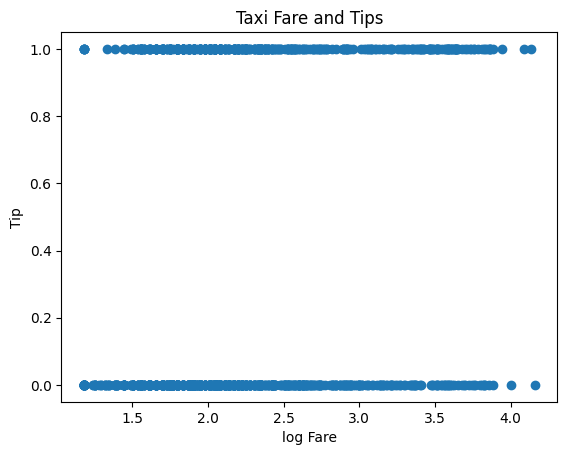

In [24]:
# Not clear relationship
plt.scatter(np.log(df_sample['fare']), df_sample['tips_encoded'])
plt.title('Taxi Fare and Tips')
plt.xlabel('log Fare')
plt.ylabel('Tip')
plt.show()

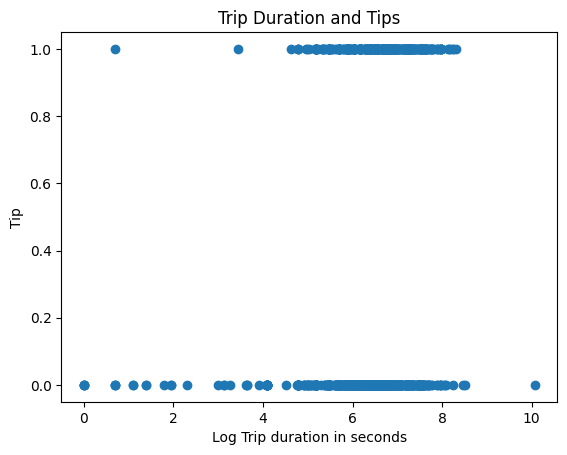

In [33]:
# Not clear relationship
plt.scatter(np.log(df_sample['trip_seconds']), df_sample['tips_encoded'])
plt.title('Trip Duration and Tips')
plt.xlabel('Log Trip duration in seconds')
plt.ylabel('Tip')
plt.show()

In [34]:
df_r = pd.read_csv("data_sources/queries/proportion_in_most_relevant_feautures.csv")

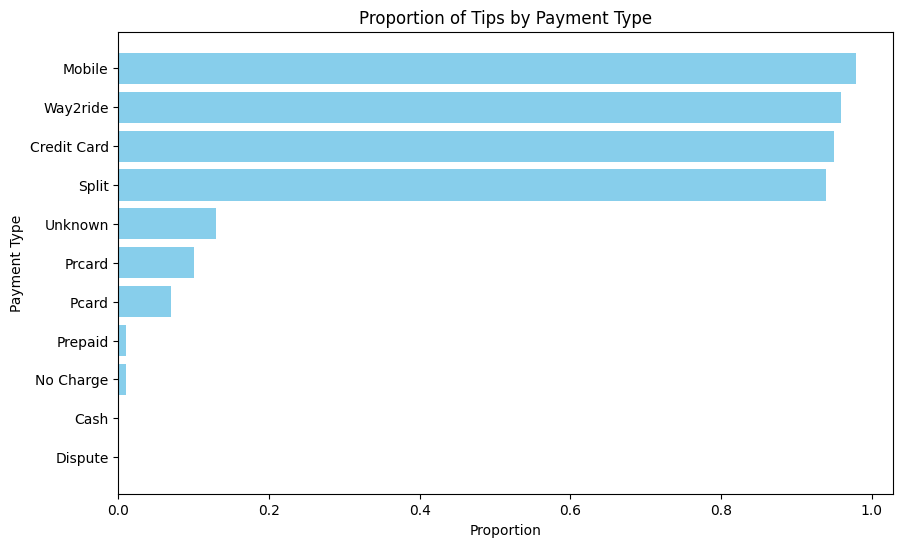

In [54]:
df_payment = df_r[(df_r['payment_type'] != 'exclude')][['proportion', 'no_observations_class', 'payment_type']]
df_payment = df_payment.sort_values(by='proportion', ascending=False)
plt.figure(figsize=(10, 6))
plt.barh(df_payment['payment_type'], df_payment['proportion'], color='skyblue')
plt.xlabel('Proportion')
plt.ylabel('Payment Type')
plt.title('Proportion of Tips by Payment Type')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest proportion on top
plt.show()

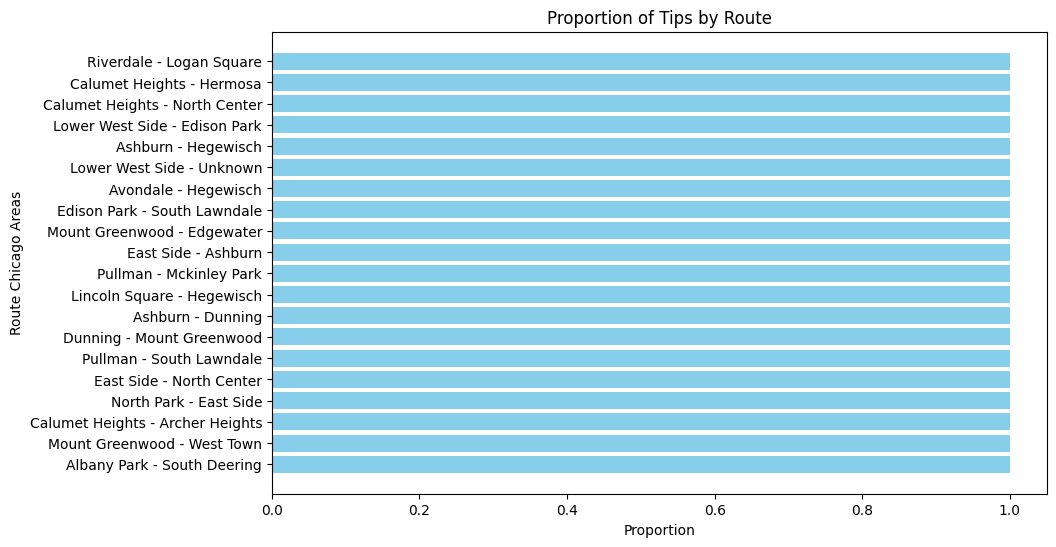

In [79]:
df_route = df_r[(df_r['route'] != 'exclude')][['proportion', 'no_observations_class', 'route']]
df_route = df_payment.sort_values(by=['proportion', 'no_observations_class'], ascending=False)
df_route = df_route.head(20)
plt.figure(figsize=(10, 6))
plt.barh(df_route['route'], df_route['proportion'], color='skyblue')
plt.xlabel('Proportion')
plt.ylabel('Route Chicago Areas')
plt.title('Proportion of Tips by Route')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest proportion on top
plt.show()

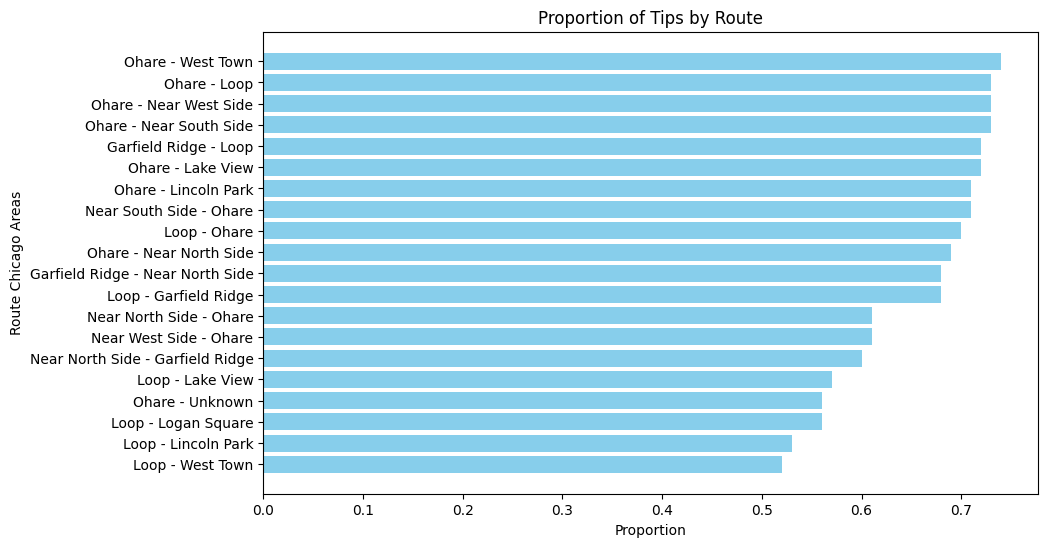

In [103]:
df_route_less = df_r[df_r['no_observations_class'] > 100000]
df_route_less = df_route_less[(df_route_less['route'] != 'exclude')][['proportion', 'no_observations_class', 'route']]
df_route_less = df_route_less.sort_values(by=['proportion', 'no_observations_class'], ascending=False)
df_route_less = df_route_less.head(20)
plt.figure(figsize=(10, 6))
plt.barh(df_route_less['route'], df_route_less['proportion'], color='skyblue')
plt.xlabel('Proportion')
plt.ylabel('Route Chicago Areas')
plt.title('Proportion of Tips by Route')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest proportion on top
plt.show()

In [14]:
X = df.drop(columns=['tips_encoded', 'trip_start_timestamp', 'trip_end_timestamp'], axis=1)
y = df['tips_encoded']
X['payment_type'] = X['payment_type'].astype('category')
X['route'] = X['route'].astype('category')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)


In [15]:
params = {'enable_categorical': True}
dtrain = xgb.DMatrix(X_train, label=y_train, enable_categorical=True)
dtest = xgb.DMatrix(X_test, label=y_test, enable_categorical=True)
model = xgb.train(params, dtrain)
y_pred = model.predict(dtest)


C:\Users\danie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:54:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "enable_categorical" } are not used.

  warnings.warn(smsg, UserWarning)


In [16]:
y_pred_class = np.where(y_pred > 0.5, 1, 0)
accuracy = accuracy_score(y_test, y_pred_class)
print("Accuracy:", accuracy)

Accuracy: 0.9745938356622317


In [17]:
model.save_model('trained_models/xgboost_model.json')

In [18]:
tree_graph = xgb.to_graphviz(model, num_trees=0)

# Export the Dot object to a text file
with open('trained_models/xgboost_tree.txt', 'w') as f:
    f.write(tree_graph.source)